Improvement in val loss ~0.10, different architectures.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from itertools import chain
from keras.preprocessing.sequence import TimeseriesGenerator
from matplotlib import pyplot as plt
from tensorflow.keras import layers
df = pd.read_csv("drive/MyDrive/Engineer's Project/test.csv")

In [ ]:
df.pop('Date')
float_data = np.array(df).astype('float32')
mean = float_data[:2500].mean(axis=0)
float_data -= mean
std = float_data[:2500].std(axis=0)
float_data /= std

In [ ]:
df.pop('usa_cpi')
df.pop('pol_cpi')
df.pop('usa_inter')
df.pop('pol_inter')

0       5.82
1       5.82
2       5.82
3       5.82
4       5.82
        ... 
3537    4.83
3538    4.83
3539    4.83
3540    4.83
3541    4.83
Name: pol_inter, Length: 3542, dtype: float64

In [ ]:
df.head()

In [ ]:
lookback = 30
step = 1
delay = 1
min_index  = 0
max_index = 2500
#max_index  = 3541
batch_size = 128

In [ ]:
def generator(data, lookback, delay, min_index, max_index,shuffle=False, batch_size=128, step=1):
  if max_index is None:
    max_index = len(data) - delay - 1
  i = min_index + lookback
  while 1:
    if shuffle:
      rows = np.random.randint(
        min_index + lookback, max_index, size=batch_size)
    else:
      if i + batch_size >= max_index:
        i = min_index + lookback
      rows = np.arange(i, min(i + batch_size, max_index))
      i += len(rows)
    samples = np.zeros((len(rows),lookback // step,data.shape[-1]))
    targets = np.zeros((len(rows),))
    for j, row in enumerate(rows):
      indices = range(rows[j] - lookback, rows[j], step)
      samples[j] = data[indices]
      targets[j] = data[rows[j] + delay][3] 
    yield samples, targets

In [ ]:
train_gen = generator(float_data,
lookback=lookback,
delay=delay,
min_index=0,
max_index=2500,
#max_index=3541,
shuffle=True,
step=step,
batch_size=batch_size)

In [ ]:
val_gen = generator(float_data,
lookback=lookback,
delay=delay,
min_index=2501,
max_index=3000,
step=step,
batch_size=batch_size)

In [ ]:
test_gen = generator(float_data,
lookback=lookback,
delay=delay,
min_index=3001,
max_index=3541,
step=step,
batch_size=batch_size)

In [ ]:
val_steps = (3000 - 2501 - lookback)
test_steps = (len(float_data) - 3001 - lookback)

Model 1 - without CPI and Interest Rate, LSTM(11) Dense(5), 200 epochs, val loss ~ 0.10

In [ ]:
model1 = tf.keras.models.Sequential()
model1.add(layers.LSTM(11,
  dropout=0.1,
  recurrent_dropout=0.1,
  input_shape=(None, float_data.shape[-1])))
model1.add(layers.Dense(5))
model1.add(layers.Dense(1))
model1.compile(optimizer= tf.keras.optimizers.RMSprop(), loss='mae')
history1 = model1.fit(train_gen,
  steps_per_epoch=200,
  epochs=200,
  validation_data=val_gen,
  validation_steps=val_steps)

Epoch 1/200
200/200 [==============================] - 12s 47ms/step - loss: 0.1605 - val_loss: 0.3372
Epoch 2/200
200/200 [==============================] - 9s 45ms/step - loss: 0.0903 - val_loss: 0.2641
Epoch 3/200
200/200 [==============================] - 9s 47ms/step - loss: 0.0818 - val_loss: 0.2284
Epoch 4/200
200/200 [==============================] - 9s 45ms/step - loss: 0.0781 - val_loss: 0.2173
Epoch 5/200
200/200 [==============================] - 9s 45ms/step - loss: 0.0751 - val_loss: 0.1852
Epoch 6/200
200/200 [==============================] - 12s 62ms/step - loss: 0.0744 - val_loss: 0.2298
Epoch 7/200
200/200 [==============================] - 9s 45ms/step - loss: 0.0731 - val_loss: 0.1614
Epoch 8/200
200/200 [==============================] - 10s 52ms/step - loss: 0.0716 - val_loss: 0.1927
Epoch 9/200
200/200 [==============================] - 9s 45ms/step - loss: 0.0709 - val_loss: 0.1691
Epoch 10/200
200/200 [==============================] - 9s 45ms/step - loss: 0.

In [ ]:
del model1

In [ ]:
eval1 = model1.evaluate(val_gen, steps = val_steps)
eval1 *std[0]

469/469 [==============================] - 4s 8ms/step - loss: 0.1013


0.03781136745277891

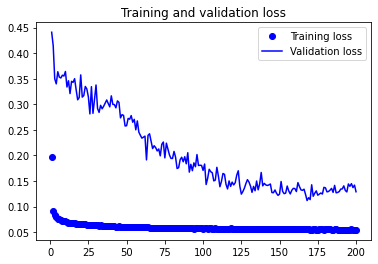

In [ ]:
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']
epochs1 = range(1, len(loss1) + 1)
plt.figure()
plt.plot(epochs1, loss1, 'bo', label='Training loss')
plt.plot(epochs1, val_loss1, 'b', label='Validation loss')
plt.title('Training and validation loss, without CPI & Interest, CLOSING PRICE PREDICTION')
plt.legend()
plt.show()

Model 2 - with CPI i Interest Rate, same architecture, val loss ~ 0.27

In [ ]:
model2 = tf.keras.models.Sequential()
model2.add(layers.LSTM(11,
  dropout=0.1,
  recurrent_dropout=0.1,
  input_shape=(None, float_data.shape[-1])))
model2.add(layers.Dense(5))
model2.add(layers.Dense(1))
model2.compile(optimizer= tf.keras.optimizers.RMSprop(), loss='mae')
history2 = model2.fit(train_gen,
  steps_per_epoch=200,
  epochs=200,
  validation_data=val_gen,
  validation_steps=val_steps)

Epoch 1/200
200/200 [==============================] - 14s 59ms/step - loss: 0.3575 - val_loss: 0.4182
Epoch 2/200
200/200 [==============================] - 12s 59ms/step - loss: 0.0931 - val_loss: 0.3986
Epoch 3/200
200/200 [==============================] - 9s 43ms/step - loss: 0.0825 - val_loss: 0.3333
Epoch 4/200
200/200 [==============================] - 9s 44ms/step - loss: 0.0778 - val_loss: 0.3326
Epoch 5/200
200/200 [==============================] - 12s 60ms/step - loss: 0.0751 - val_loss: 0.3416
Epoch 6/200
200/200 [==============================] - 12s 58ms/step - loss: 0.0733 - val_loss: 0.3324
Epoch 7/200
200/200 [==============================] - 9s 44ms/step - loss: 0.0714 - val_loss: 0.3300
Epoch 8/200
200/200 [==============================] - 9s 44ms/step - loss: 0.0714 - val_loss: 0.3242
Epoch 9/200
200/200 [==============================] - 9s 44ms/step - loss: 0.0700 - val_loss: 0.3432
Epoch 10/200
200/200 [==============================] - 9s 44ms/step - loss: 0

In [ ]:
eval2 = model2.evaluate(val_gen, steps = val_steps)
eval2 *std[0]

469/469 [==============================] - 4s 8ms/step - loss: 0.2707


0.1010919815488478

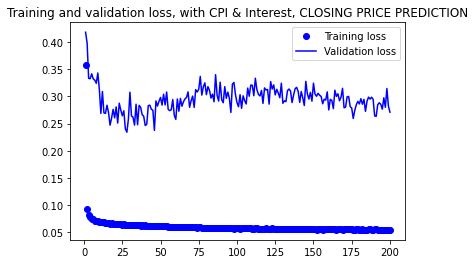

In [ ]:
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epochs2 = range(1, len(loss2) + 1)
plt.figure()
plt.plot(epochs2, loss2, 'bo', label='Training loss')
plt.plot(epochs2, val_loss2, 'b', label='Validation loss')
plt.title('Training and validation loss, with CPI & Interest, CLOSING PRICE PREDICTION')
plt.legend()
plt.show()

With data about CPI and Interest Rate the results are worse.

First model without dropout:


In [ ]:
model3 = tf.keras.models.Sequential()
model3.add(layers.LSTM(11,
  #dropout=0.1,
  #recurrent_dropout=0.1,
  input_shape=(None, float_data.shape[-1])))
model3.add(layers.Dense(5))
model3.add(layers.Dense(1))
model3.compile(optimizer= tf.keras.optimizers.RMSprop(), loss='mae')
history3 = model3.fit(train_gen,
  steps_per_epoch=200,
  epochs=200,
  validation_data=val_gen,
  validation_steps=val_steps)

Epoch 1/200
200/200 [==============================] - 13s 51ms/step - loss: 0.2469 - val_loss: 0.4140
Epoch 2/200
200/200 [==============================] - 10s 50ms/step - loss: 0.0705 - val_loss: 0.2644
Epoch 3/200
200/200 [==============================] - 11s 53ms/step - loss: 0.0626 - val_loss: 0.2319
Epoch 4/200
200/200 [==============================] - 9s 44ms/step - loss: 0.0598 - val_loss: 0.2032
Epoch 5/200
200/200 [==============================] - 10s 49ms/step - loss: 0.0586 - val_loss: 0.2026
Epoch 6/200
200/200 [==============================] - 9s 45ms/step - loss: 0.0581 - val_loss: 0.2174
Epoch 7/200
200/200 [==============================] - 7s 34ms/step - loss: 0.0574 - val_loss: 0.1835
Epoch 8/200
200/200 [==============================] - 6s 30ms/step - loss: 0.0558 - val_loss: 0.1899
Epoch 9/200
200/200 [==============================] - 6s 31ms/step - loss: 0.0560 - val_loss: 0.1993
Epoch 10/200
200/200 [==============================] - 6s 31ms/step - loss: 0

In [ ]:
eval3 = model3.evaluate(val_gen, steps = val_steps)
eval3 *std[3]

469/469 [==============================] - 3s 7ms/step - loss: 0.5073


0.18941283421037625

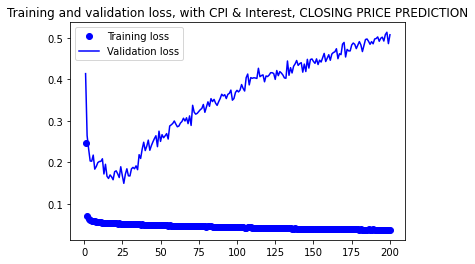

In [ ]:
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']
epochs3 = range(1, len(loss3) + 1)
plt.figure()
plt.plot(epochs3, loss3, 'bo', label='Training loss')
plt.plot(epochs3, val_loss3, 'b', label='Validation loss')
plt.title('Training and validation loss, without CPI & Interest & dropout, CLOSING PRICE PREDICTION')
plt.legend()
plt.show()

As we can see, dropout is important :) 

Model4 - without CPI and Interest Rate, LSTM(11) - GRU(32) - Dense(11), 200 epochs

In [ ]:
model4 = tf.keras.models.Sequential()
model4.add(layers.LSTM(11,
  dropout=0.1,
  recurrent_dropout=0.1,
  return_sequences=True,
  input_shape=(None, float_data.shape[-1])))
model4.add(layers.GRU(32,
  dropout=0.1,
  recurrent_dropout=0.1,
  input_shape=(None, float_data.shape[-1])))
model4.add(layers.Dense(11))
model4.add(layers.Dense(1))
model4.compile(optimizer= tf.keras.optimizers.RMSprop(), loss='mae')
history4 = model4.fit(train_gen,
  steps_per_epoch=200,
  epochs=200,
  validation_data=val_gen,
  validation_steps=val_steps)

Epoch 1/200
200/200 [==============================] - 19s 74ms/step - loss: 0.1836 - val_loss: 0.3331
Epoch 2/200
200/200 [==============================] - 14s 71ms/step - loss: 0.1031 - val_loss: 0.2698
Epoch 3/200
200/200 [==============================] - 14s 71ms/step - loss: 0.0954 - val_loss: 0.2581
Epoch 4/200
200/200 [==============================] - 15s 77ms/step - loss: 0.0915 - val_loss: 0.2501
Epoch 5/200
200/200 [==============================] - 16s 81ms/step - loss: 0.0883 - val_loss: 0.2515
Epoch 6/200
200/200 [==============================] - 14s 71ms/step - loss: 0.0856 - val_loss: 0.2200
Epoch 7/200
200/200 [==============================] - 14s 71ms/step - loss: 0.0838 - val_loss: 0.3059
Epoch 8/200
200/200 [==============================] - 16s 78ms/step - loss: 0.0832 - val_loss: 0.2141
Epoch 9/200
200/200 [==============================] - 14s 72ms/step - loss: 0.0812 - val_loss: 0.2066
Epoch 10/200
200/200 [==============================] - 14s 72ms/step - l

In [ ]:
eval4 = model4.evaluate(val_gen, steps = val_steps)
eval4 *std[3]

469/469 [==============================] - 4s 9ms/step - loss: 0.3279


0.12242172817523134

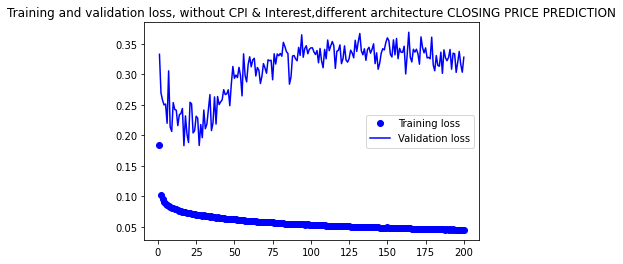

In [ ]:
loss4 = history4.history['loss']
val_loss4 = history4.history['val_loss']
epochs4 = range(1, len(loss4) + 1)
plt.figure()
plt.plot(epochs4, loss4, 'bo', label='Training loss')
plt.plot(epochs4, val_loss4, 'b', label='Validation loss')
plt.title('Training and validation loss, without CPI & Interest,different architecture CLOSING PRICE PREDICTION')
plt.legend()
plt.show()



```
# TODO:
-different loopback
-model 8-16-32-
-shuffle in train_gen
-batch_size
```



Model 5- GRU(11) - GRU(22) - Dense(5), without CPI i Interest, with dropout

In [ ]:
model5 = tf.keras.models.Sequential()
model5.add(layers.GRU(11,
  dropout=0.1,
  recurrent_dropout=0.1,
  return_sequences=True,
  input_shape=(None, float_data.shape[-1])))
model5.add(layers.GRU(22,
  dropout=0.1,
  recurrent_dropout=0.1,
  input_shape=(None, float_data.shape[-1])))
model5.add(layers.Dense(5))
model5.add(layers.Dense(1))
model5.compile(optimizer= tf.keras.optimizers.RMSprop(), loss='mae')
history5 = model5.fit(train_gen,
  steps_per_epoch=200,
  epochs=200,
  validation_data=val_gen,
  validation_steps=val_steps)

Epoch 1/200
200/200 [==============================] - 20s 75ms/step - loss: 0.1615 - val_loss: 0.1574
Epoch 2/200
200/200 [==============================] - 13s 63ms/step - loss: 0.1024 - val_loss: 0.2055
Epoch 3/200
200/200 [==============================] - 13s 63ms/step - loss: 0.0956 - val_loss: 0.2062
Epoch 4/200
200/200 [==============================] - 14s 68ms/step - loss: 0.0910 - val_loss: 0.2076
Epoch 5/200
200/200 [==============================] - 16s 80ms/step - loss: 0.0885 - val_loss: 0.2032
Epoch 6/200
200/200 [==============================] - 20s 99ms/step - loss: 0.0860 - val_loss: 0.1842
Epoch 7/200
200/200 [==============================] - 16s 79ms/step - loss: 0.0851 - val_loss: 0.1826
Epoch 8/200
200/200 [==============================] - 12s 62ms/step - loss: 0.0844 - val_loss: 0.2282
Epoch 9/200
200/200 [==============================] - 12s 62ms/step - loss: 0.0839 - val_loss: 0.2285
Epoch 10/200
200/200 [==============================] - 12s 62ms/step - l

In [ ]:
eval5 = model5.evaluate(val_gen, steps = val_steps)
eval5 *std[3]

469/469 [==============================] - 4s 9ms/step - loss: 0.2838


0.1059791814430584

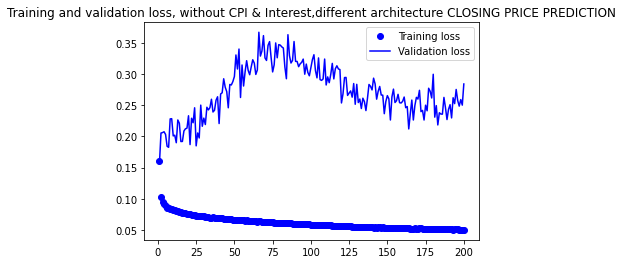

In [ ]:
loss5 = history5.history['loss']
val_loss5 = history5.history['val_loss']
epochs5 = range(1, len(loss5) + 1)
plt.figure()
plt.plot(epochs5, loss5, 'bo', label='Training loss')
plt.plot(epochs5, val_loss5, 'b', label='Validation loss')
plt.title('Training and validation loss, without CPI & Interest,different architecture CLOSING PRICE PREDICTION')
plt.legend()
plt.show()

Model 6 - different architecture

In [ ]:
model6 = tf.keras.models.Sequential()
model6.add(layers.GRU(4,
  dropout=0.1,
  recurrent_dropout=0.1,
  return_sequences=True,
  input_shape=(None, float_data.shape[-1])))
model6.add(layers.LSTM(8,
  dropout=0.1,
  recurrent_dropout=0.1,
  input_shape=(None, float_data.shape[-1])))
model6.add(layers.Dense(4))
model6.add(layers.Dense(1))
model6.compile(optimizer= tf.keras.optimizers.RMSprop(), loss='mae')
history6 = model6.fit(train_gen,
  steps_per_epoch=200,
  epochs=200,
  validation_data=val_gen,
  validation_steps=val_steps)

Epoch 1/200
200/200 [==============================] - 23s 95ms/step - loss: 0.3342 - val_loss: 0.4950
Epoch 2/200
200/200 [==============================] - 20s 99ms/step - loss: 0.1366 - val_loss: 0.3527
Epoch 3/200
200/200 [==============================] - 13s 64ms/step - loss: 0.1132 - val_loss: 0.3147
Epoch 4/200
200/200 [==============================] - 11s 56ms/step - loss: 0.1030 - val_loss: 0.2872
Epoch 5/200
200/200 [==============================] - 11s 56ms/step - loss: 0.0991 - val_loss: 0.2687
Epoch 6/200
200/200 [==============================] - 11s 56ms/step - loss: 0.0961 - val_loss: 0.2424
Epoch 7/200
200/200 [==============================] - 11s 56ms/step - loss: 0.0939 - val_loss: 0.2147
Epoch 8/200
200/200 [==============================] - 11s 57ms/step - loss: 0.0919 - val_loss: 0.2199
Epoch 9/200
200/200 [==============================] - 12s 59ms/step - loss: 0.0908 - val_loss: 0.1960
Epoch 10/200
200/200 [==============================] - 11s 57ms/step - l

In [ ]:
eval6 = model6.evaluate(val_gen, steps = val_steps)
eval6 *std[3]

469/469 [==============================] - 4s 8ms/step - loss: 0.1855


0.06928388203693014

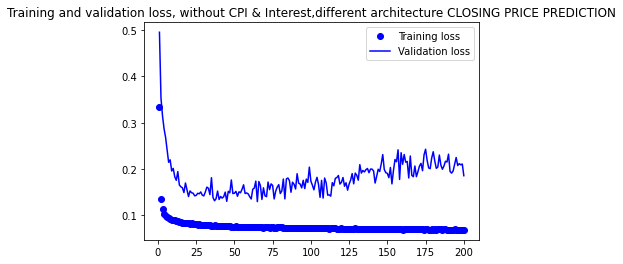

In [ ]:
loss6 = history6.history['loss']
val_loss6 = history6.history['val_loss']
epochs6 = range(1, len(loss6) + 1)
plt.figure()
plt.plot(epochs6, loss6, 'bo', label='Training loss')
plt.plot(epochs6, val_loss6, 'b', label='Validation loss')
plt.title('Training and validation loss, without CPI & Interest,different architecture CLOSING PRICE PREDICTION')
plt.legend()
plt.show()

Model 7 - same but Dense(11) - LSTM(256) - Dense(1)

In [ ]:
model7 = tf.keras.models.Sequential()
model7.add(layers.Dense(11))
model7.add(layers.LSTM(256,
  dropout=0.1,
  recurrent_dropout=0.1,
  input_shape=(None, float_data.shape[-1])))
model7.add(layers.Dense(1))
model7.compile(optimizer= tf.keras.optimizers.RMSprop(), loss='mae')
history7 = model7.fit(train_gen,
  steps_per_epoch=200,
  epochs=200,
  validation_data=val_gen,
  validation_steps=val_steps)

Epoch 1/200
200/200 [==============================] - 115s 555ms/step - loss: 0.1310 - val_loss: 0.1359
Epoch 2/200
200/200 [==============================] - 96s 482ms/step - loss: 0.0881 - val_loss: 0.0606
Epoch 3/200
200/200 [==============================] - 96s 479ms/step - loss: 0.0794 - val_loss: 0.0677
Epoch 4/200
200/200 [==============================] - 95s 473ms/step - loss: 0.0734 - val_loss: 0.0698
Epoch 5/200
200/200 [==============================] - 95s 475ms/step - loss: 0.0694 - val_loss: 0.0704
Epoch 6/200
200/200 [==============================] - 95s 478ms/step - loss: 0.0658 - val_loss: 0.1162
Epoch 7/200
200/200 [==============================] - 95s 477ms/step - loss: 0.0631 - val_loss: 0.1146
Epoch 8/200
200/200 [==============================] - 95s 476ms/step - loss: 0.0606 - val_loss: 0.1047
Epoch 9/200
200/200 [==============================] - 95s 477ms/step - loss: 0.0579 - val_loss: 0.1098
Epoch 10/200
200/200 [==============================] - 95s 477

In [ ]:
eval7 = model7.evaluate(val_gen, steps = val_steps)
eval7 *std[3]

469/469 [==============================] - 34s 72ms/step - loss: 0.2734


0.10209650867642939

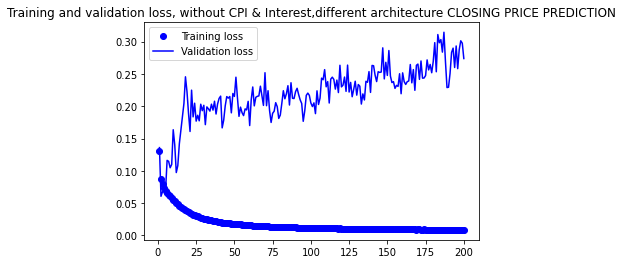

In [ ]:
loss7 = history7.history['loss']
val_loss7 = history7.history['val_loss']
epochs7 = range(1, len(loss7) + 1)
plt.figure()
plt.plot(epochs7, loss7, 'bo', label='Training loss')
plt.plot(epochs7, val_loss7, 'b', label='Validation loss')
plt.title('Training and validation loss, without CPI & Interest,different architecture CLOSING PRICE PREDICTION')
plt.legend()
plt.show()

Model 8 - smaller number of neurons

In [ ]:
model8 = tf.keras.models.Sequential()
model8.add(layers.GRU(3,
  dropout=0.1,
  recurrent_dropout=0.1,
  return_sequences=True,
  input_shape=(None, float_data.shape[-1])))
model8.add(layers.LSTM(4,
  dropout=0.1,
  recurrent_dropout=0.1,
  return_sequences=True,
  input_shape=(None, float_data.shape[-1])))
model8.add(layers.GRU(3,
  dropout=0.1,
  recurrent_dropout=0.1,
  input_shape=(None, float_data.shape[-1])))
model8.add(layers.Dense(1))
model8.compile(optimizer= tf.keras.optimizers.RMSprop(), loss='mae')
history8 = model8.fit(train_gen,
  steps_per_epoch=200,
  epochs=200,
  validation_data=val_gen,
  validation_steps=val_steps)

Epoch 1/200
200/200 [==============================] - 36s 126ms/step - loss: 0.4121 - val_loss: 0.6740
Epoch 2/200
200/200 [==============================] - 19s 95ms/step - loss: 0.2189 - val_loss: 0.4894
Epoch 3/200
200/200 [==============================] - 16s 81ms/step - loss: 0.1565 - val_loss: 0.4673
Epoch 4/200
200/200 [==============================] - 16s 81ms/step - loss: 0.1335 - val_loss: 0.4370
Epoch 5/200
200/200 [==============================] - 17s 85ms/step - loss: 0.1238 - val_loss: 0.4733
Epoch 6/200
200/200 [==============================] - 16s 81ms/step - loss: 0.1201 - val_loss: 0.4179
Epoch 7/200
200/200 [==============================] - 16s 81ms/step - loss: 0.1167 - val_loss: 0.4177
Epoch 8/200
200/200 [==============================] - 17s 84ms/step - loss: 0.1141 - val_loss: 0.3912
Epoch 9/200
200/200 [==============================] - 17s 84ms/step - loss: 0.1119 - val_loss: 0.3890
Epoch 10/200
200/200 [==============================] - 17s 84ms/step - 

In [ ]:
eval8 = model8.evaluate(val_gen, steps = val_steps)
eval8 *std[3]

469/469 [==============================] - 5s 11ms/step - loss: 0.2386


0.08909989189126888

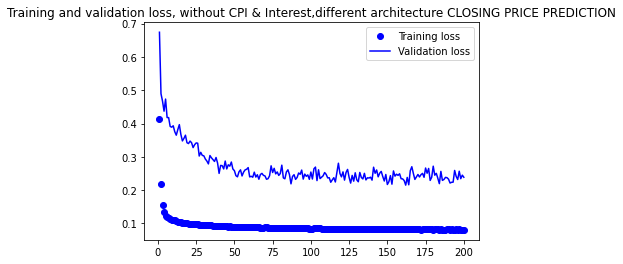

In [ ]:
loss8 = history8.history['loss']
val_loss8 = history8.history['val_loss']
epochs8 = range(1, len(loss8) + 1)
plt.figure()
plt.plot(epochs8, loss8, 'bo', label='Training loss')
plt.plot(epochs8, val_loss8, 'b', label='Validation loss')
plt.title('Training and validation loss, without CPI & Interest,different architecture CLOSING PRICE PREDICTION')
plt.legend()
plt.show()

In [ ]:
model9 = tf.keras.models.Sequential()
model9.add(layers.LSTM(11,
  dropout=0.1,
  recurrent_dropout=0.1,
  return_sequences=True,
  input_shape=(None, float_data.shape[-1])))
model9.add(layers.LSTM(6,
  dropout=0.1,
  recurrent_dropout=0.1,
  input_shape=(None, float_data.shape[-1])))
model9.add(layers.Dense(3))
model9.add(layers.Dense(1))
model9.compile(optimizer= tf.keras.optimizers.RMSprop(), loss='mae')
history9 = model9.fit(train_gen,
  steps_per_epoch=200,
  epochs=200,
  validation_data=val_gen,
  validation_steps=val_steps)

Epoch 1/200
200/200 [==============================] - 18s 68ms/step - loss: 0.2472 - val_loss: 0.1912
Epoch 2/200
200/200 [==============================] - 13s 66ms/step - loss: 0.0975 - val_loss: 0.2673
Epoch 3/200
200/200 [==============================] - 13s 65ms/step - loss: 0.0885 - val_loss: 0.2765
Epoch 4/200
200/200 [==============================] - 13s 66ms/step - loss: 0.0851 - val_loss: 0.2799
Epoch 5/200
200/200 [==============================] - 13s 66ms/step - loss: 0.0830 - val_loss: 0.2294
Epoch 6/200
200/200 [==============================] - 13s 66ms/step - loss: 0.0810 - val_loss: 0.2473
Epoch 7/200
200/200 [==============================] - 14s 68ms/step - loss: 0.0799 - val_loss: 0.2512
Epoch 8/200
200/200 [==============================] - 14s 68ms/step - loss: 0.0776 - val_loss: 0.2442
Epoch 9/200
200/200 [==============================] - 14s 70ms/step - loss: 0.0765 - val_loss: 0.2526
Epoch 10/200
200/200 [==============================] - 13s 66ms/step - l

In [ ]:
eval9 = model9.evaluate(val_gen, steps = val_steps)
eval9 *std[3]

469/469 [==============================] - 9s 18ms/step - loss: 0.2186


0.08162619973316332

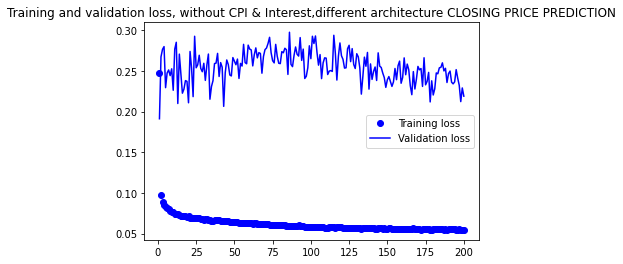

In [ ]:
loss9 = history9.history['loss']
val_loss9 = history9.history['val_loss']
epochs9 = range(1, len(loss9) + 1)
plt.figure()
plt.plot(epochs9, loss9, 'bo', label='Training loss')
plt.plot(epochs9, val_loss9, 'b', label='Validation loss')
plt.title('Training and validation loss, without CPI & Interest,different architecture CLOSING PRICE PREDICTION')
plt.legend()
plt.show()

In [ ]:
model10 = tf.keras.models.Sequential()
model10.add(layers.GRU(11,
  dropout=0.1,
  recurrent_dropout=0.1,
  return_sequences=True,
  input_shape=(None, float_data.shape[-1])))
model10.add(layers.GRU(3,
  dropout=0.1,
  recurrent_dropout=0.1,
  input_shape=(None, float_data.shape[-1])))
model10.add(layers.Dense(2))
model10.add(layers.Dense(1))
model10.compile(optimizer= tf.keras.optimizers.RMSprop(), loss='mae')
history10 = model10.fit(train_gen,
  steps_per_epoch=200,
  epochs=200,
  validation_data=val_gen,
  validation_steps=val_steps)

Epoch 1/200
200/200 [==============================] - 21s 83ms/step - loss: 0.2762 - val_loss: 0.1885
Epoch 2/200
200/200 [==============================] - 17s 84ms/step - loss: 0.1180 - val_loss: 0.1968
Epoch 3/200
200/200 [==============================] - 17s 87ms/step - loss: 0.1023 - val_loss: 0.2089
Epoch 4/200
200/200 [==============================] - 14s 70ms/step - loss: 0.0929 - val_loss: 0.1900
Epoch 5/200
200/200 [==============================] - 15s 74ms/step - loss: 0.0904 - val_loss: 0.1863
Epoch 6/200
200/200 [==============================] - 14s 70ms/step - loss: 0.0873 - val_loss: 0.2117
Epoch 7/200
200/200 [==============================] - 11s 55ms/step - loss: 0.0855 - val_loss: 0.2074
Epoch 8/200
200/200 [==============================] - 11s 56ms/step - loss: 0.0845 - val_loss: 0.2176
Epoch 9/200
200/200 [==============================] - 11s 56ms/step - loss: 0.0839 - val_loss: 0.2120
Epoch 10/200
200/200 [==============================] - 11s 55ms/step - l

In [ ]:
eval10 = model10.evaluate(val_gen, steps = val_steps)
eval10 *std[3]

469/469 [==============================] - 4s 8ms/step - loss: 0.1904


0.07108054071910352

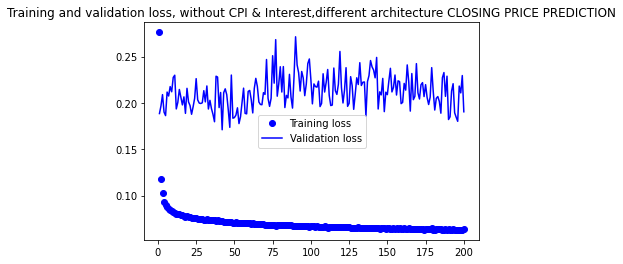

In [ ]:
loss10 = history10.history['loss']
val_loss10 = history10.history['val_loss']
epochs10 = range(1, len(loss10) + 1)
plt.figure()
plt.plot(epochs9, loss10, 'bo', label='Training loss')
plt.plot(epochs9, val_loss10, 'b', label='Validation loss')
plt.title('Training and validation loss, without CPI & Interest,different architecture CLOSING PRICE PREDICTION')
plt.legend()
plt.show()